# Gradient descent implementations in SciPy Optimize.

## Needed Libraries import

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import random

## Helper functions for plots and output formatting


In [306]:
def plot(func, results_list, grid):
    if not isinstance(results_list, list):
        results_list = [results_list]

    x, y = np.meshgrid(np.linspace(grid[0], grid[1], 200), np.linspace(grid[0], grid[1], 200))

    z = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = func((x[i, j], y[i, j]))

    plt.figure()
    plt.contour(x, y, z, levels=30)

    for res in results_list:
        path = res.x_history
        plt.plot(path[:, 0], path[:, 1], label="GD path", marker='o')
        plt.plot(path[-1, 0], path[-1, 1], 'x', markersize=10)

    plt.xlim(grid)
    plt.ylim(grid)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()


def print_output(init, gd, func, grad, optimum, grid=(-6, 6)):
    res = gd(func, grad, init)
    error = np.linalg.norm(res.x - optimum)

    print(f"{'=' * 90}")
    print(f"Method: {gd.__name__}")
    print(f"Initial point: {init}")
    print(f"Real minimum: {optimum}")
    print(f"{'=' * 90}")
    print(f"{'Method':<15} {'Found point':<20} {'f(x)':<10} {'Iterations':<15} {'Evals':<12} {'Error':<10}")
    print(f"{'-' * 90}")
    print(
        f"{'Stat':<15} ({res.x[0]:.3f}, {res.x[1]:.3f}) {" ":<5} {res.fun:<13.3f} {res.nit:<13} {res.nfev:<10} {error:<10.6f}")
    print(f"{'=' * 90}")

    plot(func, res, grid)

## Functions for research

### Rastrigin function

In [307]:
def rastrigin(point, a=1):
    x, y = point
    return (a * 2
            + (x ** 2 - a * math.cos(2 * math.pi * x))
            + (y ** 2 - a * math.cos(2 * math.pi * y)))


def grad_rastrigin(point, a=1):
    x, y = point
    return np.array([2 * x + a * 2 * np.pi * np.sin(2 * np.pi * x),
                     2 * y + a * 2 * np.pi * np.sin(2 * np.pi * y)])

### Rastrigin function with noise

In [308]:
def rastrigin_noisy(point, a=1, sigma=0.1):
    return rastrigin(point, a=a) + random.gauss(0, sigma)


def grad_rastrigin_noisy(point, a=1, sigma=0.1):
    return grad_rastrigin(point, a=a) + random.gauss(0, sigma)

## Gradient Descent implementations

### GD based on golden-section search

In [309]:
def golden_section_search(f, a, b, tol=1e-6, max_iter=1000):
    golden_ratio = (np.sqrt(5) - 1) / 2

    nfev = 0

    x1 = b - golden_ratio * (b - a)
    x2 = a + golden_ratio * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    nfev += 2

    nit = 0
    for nit in range(max_iter):
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + golden_ratio * (b - a)
            f2 = f(x2)
            nfev += 1
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - golden_ratio * (b - a)
            f1 = f(x1)
            nfev += 1

        if abs(b - a) < tol:
            break

    x_min = (a + b) / 2
    f_min = f(x_min)
    nfev += 1

    result = opt.OptimizeResult(
        x=x_min,
        fun=f_min,
        nfev=nfev,
        nit=nit + 1,
        success=abs(b - a) < tol,
        status=0 if abs(b - a) < tol else 1,
    )

    return result


def gd_gs(f, grad_f, x0, tol=1e-6, max_iter=10000):
    x = np.array(x0, dtype=float)

    nit = 0
    nfev = 1
    ngev = 0
    x_history = [x.copy()]

    for nit in range(max_iter):
        g = grad_f(x)
        ngev += 1

        if np.linalg.norm(g) < tol:
            break

        d = -g

        def f_along_line(alpha):
            return f(x + alpha * d)

        alpha_result = golden_section_search(f_along_line, 0, 1.0)
        alpha = alpha_result.x
        nfev += alpha_result.nfev

        x_new = x + alpha * d
        x_history.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            nfev += 1
            break

        x = x_new
        nfev += 1

    fun = f(x)

    result = opt.OptimizeResult(
        x=x,
        fun=fun,
        jac=g,
        nfev=nfev,
        njev=ngev,
        nit=nit + 1,
        success=nit < max_iter - 1 or np.linalg.norm(g) < tol,
        x_history=np.array(x_history)
    )

    return result

### GD with adaptive learning rate, SciPy implementation

In [310]:
def gd_adaptive_lr_opt(func, grad, init, max_iter=1000, tol=1e-6):
    x_history = [np.array(init, dtype=float)]

    def callback(xk):
        x_history.append(np.array(xk, dtype=float))

    result = opt.minimize(func, x0=init, jac=grad, method='BFGS', tol=tol, callback=callback,
                          options={'maxiter': max_iter})

    result.x_history = np.array(x_history)

    return result

### GD based on SciPy line search

In [311]:
def gd_line_search_opt(func, grad, init, max_iter=1000, tol=1e-6):
    x = np.array(init, dtype=float)
    x_history = [x.copy()]
    f_history = [func(x)]
    nit = 0
    nfev = 1
    for i in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break

        def line_search_func(alpha):
            nonlocal nfev
            nfev += 1
            return func(x - alpha * g)

        res = opt.minimize_scalar(line_search_func, method='golden', tol=1e-6)

        x = x - res.x * g

        x_history.append(x.copy())
        f_val = func(x)
        f_history.append(f_val)
        nit += 1
        nfev += 1

        if np.linalg.norm(x_history[-1] - x_history[-2]) < tol:
            break

    return opt.OptimizeResult(
        x=x,
        fun=func(x),
        jac=grad(x),
        nit=nit,
        nfev=nfev,
        x_history=np.array(x_history),
        f_history=np.array(f_history)
    )

## Results

### Research of rastrigin function

Method: gd_gs
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-0.000, 0.000)       0.000         3             67         0.000000  


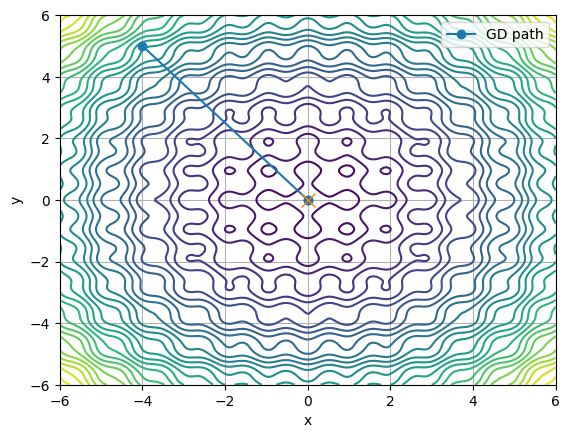

Method: gd_adaptive_lr_opt
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-0.951, 0.951)       1.903         7             13         1.344989  


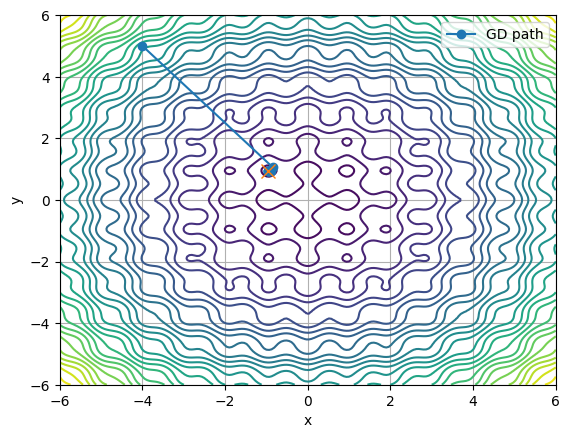

Method: gd_line_search_opt
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (0.000, -0.000)       0.000         2             82         0.000000  


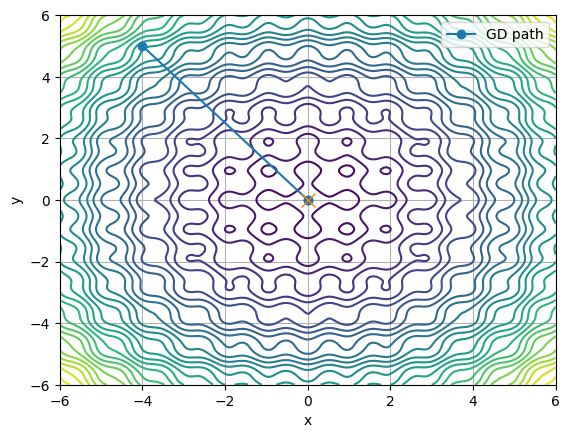

In [312]:
print_output([-4, 5], gd_gs, rastrigin, grad_rastrigin, [0, 0])
print_output([-4, 5], gd_adaptive_lr_opt, rastrigin, grad_rastrigin, [0, 0])
print_output([-4, 5], gd_line_search_opt, rastrigin, grad_rastrigin, [0, 0])

### Research of noisy rastrigin function

Method: gd_gs
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-0.071, 0.940)       1.120         10000         330001     0.942259  


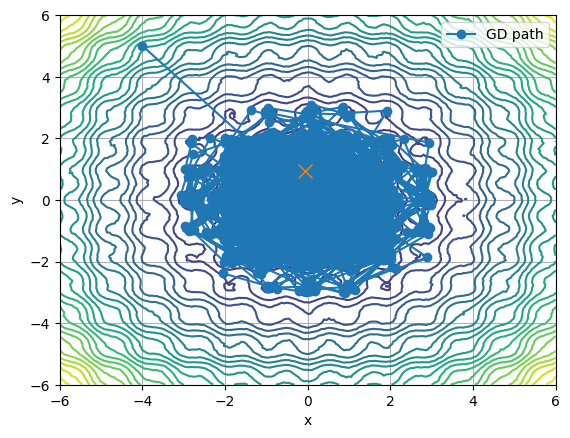

Method: gd_adaptive_lr_opt
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-0.948, 0.952)       1.687         5             48         1.343713  


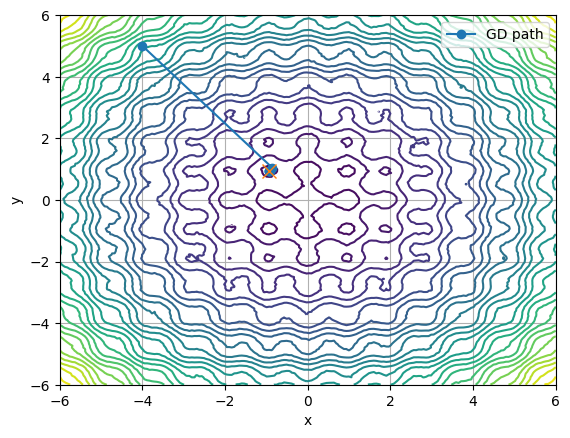

Method: gd_line_search_opt
Initial point: [-4, 5]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-0.026, -0.027)       0.016         49            2508       0.037465  


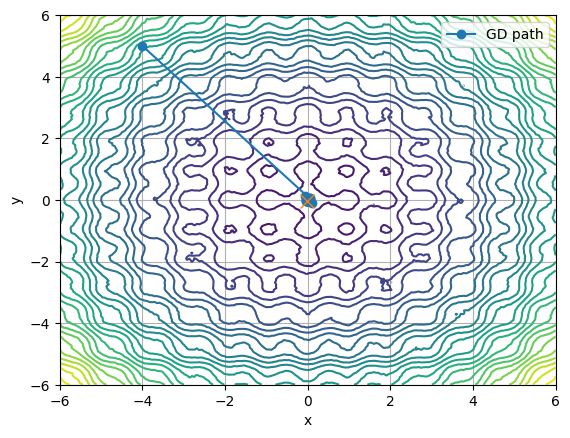

In [313]:
print_output([-4, 5], gd_gs, rastrigin_noisy, grad_rastrigin_noisy, [0, 0])
print_output([-4, 5], gd_adaptive_lr_opt, rastrigin_noisy, grad_rastrigin_noisy, [0, 0])
print_output([-4, 5], gd_line_search_opt, rastrigin_noisy, grad_rastrigin_noisy, [0, 0])